Importing necessary libraries 

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import numpy as np

Processing data

In [44]:
data = pd.read_csv('Dataset.csv')

In [45]:
features = ['AP', 'RP', 'experience_dive', 'experience_discipline', 'Month', 'Year']
X = data[features]
y = data['Card']  # Target

The objective is to predict dive card categories (RED, WHITE, YELLOW) based on features like announced depth, achieved depth, diver experience, and date.

In [46]:
card_counts = data['Card'].value_counts()
print(card_counts)

Card
WHITE     22409
YELLOW     5898
RED        3064
Name: count, dtype: int64


Each feature likely has a relationship with the target 'Card'.
For instance, experience (experience_dive, experience_discipline) and performance (AP, RP).

And we can see it from the graphs in (Data_Exp.ipynb)

Fill missing numerical values with mean

In [47]:
X = X.fillna(X.mean())

In [48]:
# Convert categorical features in X to binary columns
X = pd.get_dummies(X, drop_first=True)

1st Method

Scaling the features and splitting data into train and test

In [49]:
''' 
Standardize the feature values in X to have a mean of 0 and standard
deviation of 1, improving model performance by ensuring features are on the
same scale
'''

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:

#Split standardized data into training(70%) and testing(30%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42) 

The choice of SVM is motivated by its theoretical strong performance as a classifier for problems with non-linear decision boundaries. The linear kernel is suitable when the classes are linearly separable, while the RBF kernel often performs better for problems with complex non-linear relationships between classes. The polynomial kernel is also an interesting option as it can capture intermediate complexity relationships between the data. Comparing these kernels allowed us to determine which model best matched the distribution of the data.

SVM classifier with linear kernel

In [51]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train) #Train the SVM model

y_pred = svm.predict(X_test) # Make predictions on the test set

report = classification_report(y_test, y_pred) # Evaluate model performance
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

         RED       0.00      0.00      0.00       953
       WHITE       0.87      0.99      0.93      6692
      YELLOW       0.80      0.81      0.80      1767

    accuracy                           0.86      9412
   macro avg       0.56      0.60      0.58      9412
weighted avg       0.77      0.86      0.81      9412



c:\Users\amina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

The model performs very well on the WHITE class, with high precision, recall, and F1-score.

But it completely fails to predict the RED class (0 precision , 0 recall), wich is a major issue.

The YELLOW class has moderate performance, but still lags behind WHITE.

RED is the major class, while WHITE and YELLOW are minority classes.
So, these classes are imbalanced, I will use class weights.

2nd Method

X and y are features and target

In [52]:
data = pd.DataFrame(X)
data['target'] = y

In [53]:
# filter data
data_red = data[data['target'] == 'RED']
data_white = data[data['target'] == 'WHITE']
data_yellow = data[data['target'] == 'YELLOW']

To address imbalance, 5,000 random WHITE samples were taken, reducing training size while ensuring fairer weight for YELLOW and RED. This was repeated multiple times to confirm model consistency.

In [54]:
''' 
Sample 5000 random rows from the WHITE, the number of instances of the WHITE
is reduced, which helps balance the class distribution.
'''
data_white_sampled = data_white.sample(n=5000, random_state=42)

In [55]:
# Combine the data from three different classes into a single balanced dataset
data_balanced = pd.concat([data_red, data_white_sampled, data_yellow], axis=0)

# Split the balanced dataset into features and target
X_balanced = data_balanced.drop(columns=['target']).values
y_balanced = data_balanced['target'].values

In [56]:
label_encoder = LabelEncoder()
y_balanced_encoded = label_encoder.fit_transform(y_balanced)

Split data into train , validation and test

In [57]:
'''
if I only split data into Training and Testing sets, maybe there will be
Overfitting (the model could just memorize the data instead of learning)

Thanks to validation, I can check the model's performance to ensure it is
generalizing well and not overfitting.
'''

"\nif I only split data into Training and Testing sets, maybe there will be\nOverfitting (the model could just memorize the data instead of learning)\n\nThanks to validation, I can check the model's performance to ensure it is\ngeneralizing well and not overfitting.\n"

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_balanced, y_balanced_encoded, test_size=0.3, stratify=y_balanced_encoded, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

SVM with linear kernel

In [60]:
class_weight_dict = {0: 2.2, 1: 1.0, 2: 2.0}  # weights for each class
svm = SVC(kernel='linear', class_weight=class_weight_dict, C=1.0)

svm.fit(X_train_scaled, y_train) # Train the SVM 

y_val_pred = svm.predict(X_val_scaled) # Make predictions on the validation set

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

y_test_pred = svm.predict(X_test_scaled) # Make predictions on the test set

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Validation Classification Report:
              precision    recall  f1-score   support

         RED       0.34      0.45      0.39       459
       WHITE       0.72      0.50      0.59       750
      YELLOW       0.82      0.89      0.86       885

    accuracy                           0.66      2094
   macro avg       0.63      0.61      0.61      2094
weighted avg       0.68      0.66      0.66      2094

Test Classification Report:
              precision    recall  f1-score   support

         RED       0.33      0.46      0.39       460
       WHITE       0.71      0.50      0.58       750
      YELLOW       0.84      0.88      0.86       885

    accuracy                           0.65      2095
   macro avg       0.63      0.61      0.61      2095
weighted avg       0.68      0.65      0.66      2095



Low performance for the RED class with low precision and recall, indicating
difficulty in predicting this minority class. 

The WHITE class also has low recall, while YELLOW performs better with high recall.

Switching to non-linear kernel may improve model performance.

In [61]:
accuracy_linear = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy_linear}")

Accuracy: 0.6556829035339063


In [62]:
precision_linear = precision_score(y_val, y_val_pred, average='macro')
print(f"Accuracy: {precision_linear}")

Accuracy: 0.6257085385720149


In [63]:
recall_linear = recall_score(y_val, y_val_pred, average='macro')
print(f"Accuracy: {recall_linear}")

Accuracy: 0.6142905604175128


SVM with poly kernel

In [64]:
class_weight_dict = {0: 2.2, 1: 1.0, 2: 2.0}  # weights for each class
svm = SVC(kernel='poly', class_weight=class_weight_dict, C=1.0)

svm.fit(X_train_scaled, y_train) # Train SVM

y_val_pred = svm.predict(X_val_scaled)

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

y_test_pred = svm.predict(X_test_scaled)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Validation Classification Report:
              precision    recall  f1-score   support

         RED       0.41      0.43      0.42       459
       WHITE       0.80      0.16      0.27       750
      YELLOW       0.56      0.93      0.70       885

    accuracy                           0.54      2094
   macro avg       0.59      0.51      0.46      2094
weighted avg       0.61      0.54      0.48      2094

Test Classification Report:
              precision    recall  f1-score   support

         RED       0.39      0.42      0.40       460
       WHITE       0.77      0.17      0.28       750
      YELLOW       0.56      0.92      0.70       885

    accuracy                           0.54      2095
   macro avg       0.58      0.50      0.46      2095
weighted avg       0.60      0.54      0.48      2095



RED class still has low precision and recall, but it is slightly better than with linear kernel.

WHITE has very low recall, suggesting it is poorly predicted, while YELLOW has high recall but low precision.

So, the results still indicate the need for further adjustments.

In [65]:
accuracy_poly = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy_poly}")

Accuracy: 0.543935052531041


In [66]:
precision_poly = precision_score(y_val, y_val_pred, average='macro')
print(f"Accuracy: {precision_poly}")

Accuracy: 0.5906659954984347


In [67]:
recall_poly = recall_score(y_val, y_val_pred, average='macro')
print(f"Accuracy: {recall_poly}")

Accuracy: 0.5067694201346576


SVM with rbf kernel

In [68]:
class_weight_dict = {0: 2.2, 1: 1.0, 2: 2.0}  # weights for each class
svm = SVC(kernel='rbf', class_weight=class_weight_dict, C=1.0)

svm.fit(X_train_scaled, y_train)

y_val_pred = svm.predict(X_val_scaled)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

y_test_pred = svm.predict(X_test_scaled)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Validation Classification Report:
              precision    recall  f1-score   support

         RED       0.41      0.56      0.47       459
       WHITE       0.70      0.55      0.62       750
      YELLOW       0.85      0.85      0.85       885

    accuracy                           0.68      2094
   macro avg       0.66      0.65      0.65      2094
weighted avg       0.70      0.68      0.68      2094

Test Classification Report:
              precision    recall  f1-score   support

         RED       0.41      0.61      0.49       460
       WHITE       0.69      0.54      0.61       750
      YELLOW       0.87      0.81      0.84       885

    accuracy                           0.67      2095
   macro avg       0.66      0.66      0.65      2095
weighted avg       0.71      0.67      0.68      2095



The RBF kernel has improved the performance compared to the linear and polynomial kernels.

The RED class now has better recall (56% val, 61% test), indicating a somewhat better ability to identify this class.

WHITE still has low recall (55% val, 54% test), but it is somewhat improved compared to the previous kernels.

YELLOW maintains a strong recall (85% val, 81% test) .

RBF kernel effectively handles non-linear separations, improving performance for imbalanced datasets.

In [69]:
accuracy_rbf = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy_rbf}")

Accuracy: 0.6776504297994269


In [70]:
precision_rbf = precision_score(y_val, y_val_pred, average='macro')
print(f"Accuracy: {precision_rbf}")

Accuracy: 0.6552889434979783


In [71]:
recall_rbf = recall_score(y_val, y_val_pred, average='macro')
print(f"Accuracy: {recall_rbf}")

Accuracy: 0.6524485801853698


Confusion Matrix

In [72]:
matrix = confusion_matrix(y_val, y_val_pred)
matrix

array([[258, 115,  86],
       [298, 410,  42],
       [ 76,  58, 751]], dtype=int64)

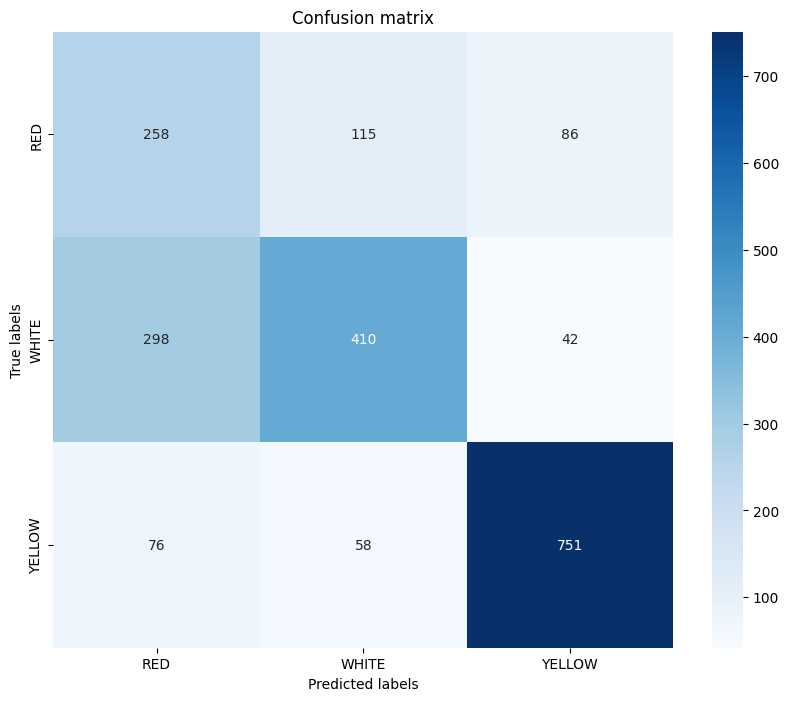

In [73]:
plt.figure(figsize=(10,8))
sns.heatmap(
    matrix, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
    )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

The model performs well for YELLOW (751 correct predictions).

RED still has a significant number of misclassifications as WHITE and YELLOW, suggesting that the model struggles more with RED.

WHITE is predicted with reasonable degree of accuracy(410 correct0).

The confusion matrix indicates that the model performs better with YELLOW, with relatively high number of true positives. However, it struggles more with RED and WHITE, showing misclassifications, espicially between RED and WHITE.

3rd Method

SVM rbf kernel with C=25 and gamma=0.1

In [74]:
n_iterations = 5 
reports = []

In [75]:
for i in range(n_iterations):
    data_white_sampled = data_white.sample(n=5000, random_state=i)
    data_balanced = pd.concat([data_red, data_white_sampled, data_yellow], axis=0)
    
    X_balanced = data_balanced.drop(columns=['target']).values
    y_balanced = data_balanced['target'].values

    y_balanced_encoded = label_encoder.fit_transform(y_balanced)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X_balanced, y_balanced_encoded, test_size=0.3, stratify=y_balanced_encoded, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    class_weight_dict = {0: 2.4, 1: 1.1, 2: 2.0}
    
    
    svm = SVC(kernel='rbf', class_weight=class_weight_dict, C=25, gamma=0.1)
    svm.fit(X_train_scaled, y_train)

    
    y_val_pred = svm.predict(X_val_scaled)
    report = classification_report(y_val, y_val_pred, target_names=label_encoder.classes_, output_dict=True)
    reports.append(report)

avg_precision = np.mean([r['weighted avg']['precision'] for r in reports])
avg_recall = np.mean([r['weighted avg']['recall'] for r in reports])
avg_f1 = np.mean([r['weighted avg']['f1-score'] for r in reports])


In [76]:
avg_precision, avg_recall, avg_f1

(0.7180694328088949, 0.6966571155682904, 0.7051723588852584)

Iterations are used to evaluate the stability of the model's performance across different random samples of the WHITE class to minimize variance and overfitting.

I increased C, to help the model focus more on correctly classifying training examples.

I added gamma and setting it to 0.1, allows the model to learn complex decision boundaries while avoiding overfitting.

Random Forest Classifier

I decided to change the model from SVM to Random Forest Classifier. the reason is to explore a different approach to handle class imbalance and model complexity.

Why Random Forest?
 - Robust, ensemble-based model that minimizes overfitting while capturing complex patterns.
 
Automatically adjusts for class imbalance using Balanced weight mode.

In [85]:
rf = RandomForestClassifier(   
    n_estimators=200,         # Number of trees
    max_depth=20,             # Maximum depth of trees
    min_samples_split=10,     # Minimum samples to split a node
    min_samples_leaf=5,       # Minimum samples per leaf
    class_weight='balanced',  # Handle class imbalance by adjusting weights
    random_state=42
)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_val_scaled)

print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

y_test_pred = rf.predict(X_test_scaled)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

         RED       0.52      0.44      0.48       459
       WHITE       0.67      0.78      0.72       750
      YELLOW       0.87      0.83      0.85       885

    accuracy                           0.72      2094
   macro avg       0.69      0.68      0.68      2094
weighted avg       0.72      0.72      0.72      2094

Test Classification Report:
              precision    recall  f1-score   support

         RED       0.48      0.45      0.47       460
       WHITE       0.67      0.75      0.71       750
      YELLOW       0.88      0.81      0.85       885

    accuracy                           0.71      2095
   macro avg       0.68      0.67      0.67      2095
weighted avg       0.72      0.71      0.71      2095



This switch has helped significantly improve the performance.

In [78]:
matrix2 = confusion_matrix(y_val, y_val_pred)
matrix2

array([[238, 142,  79],
       [241, 505,   4],
       [ 72,  69, 744]], dtype=int64)

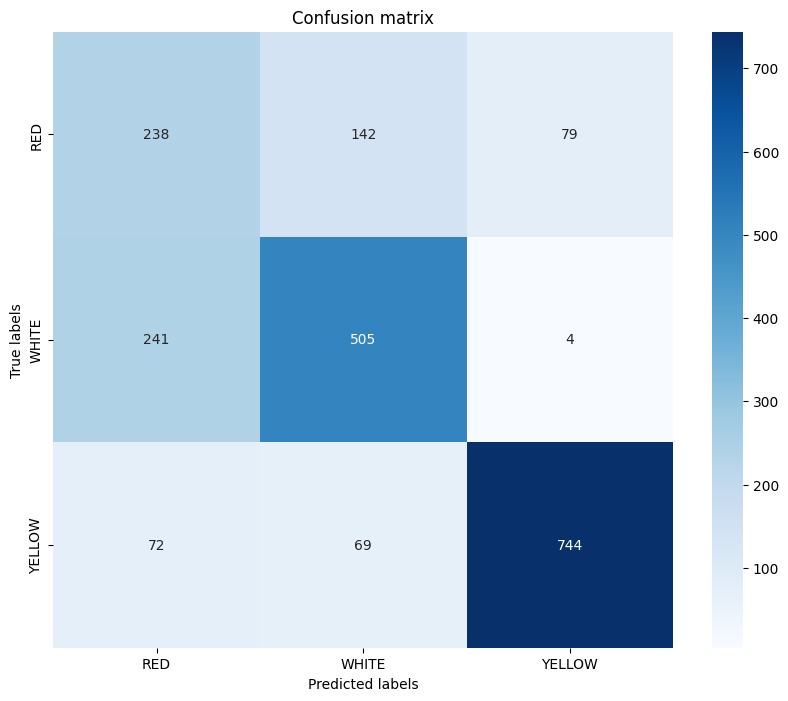

In [79]:
plt.figure(figsize=(10,8))
sns.heatmap(
    matrix2, annot=True, fmt='d', cmap='Blues', 
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
    )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

The model now has a more balanced performance across all classes.

In [80]:
accuracy_RFC = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy_RFC}")

Accuracy: 0.710124164278892


In [81]:
precision_RFC = precision_score(y_val, y_val_pred, average='macro')
print(f"Precision: {precision_RFC}")

Precision: 0.6789621431306485


In [82]:
recall_RFC = recall_score(y_val, y_val_pred, average='macro')
print(f"Recall: {recall_RFC}")

Recall: 0.677509939317849


Comparaison

In [83]:
# dictionary of results
results = {
    'Model': ['Random Forest', 'SVM (Linear)', 'SVM (RBF)', 'SVM (Polynomial)'],
    'Accuracy': [accuracy_RFC, accuracy_linear, accuracy_rbf, accuracy_poly],
    'Precision': [precision_RFC, precision_linear, precision_rbf, precision_poly],
    'Recall': [recall_RFC, recall_linear, recall_rbf, recall_poly]
}

results_df = pd.DataFrame(results)


In [84]:
results_df

,Model,Accuracy,Precision,Recall
0,Random Forest,0.710124,0.678962,0.677510
1,SVM (Linear),0.655683,0.625709,0.614291
2,SVM (RBF),0.677650,0.655289,0.652449
3,SVM (Polynomial),0.543935,0.590666,0.506769


Best Model: Random Forest is the best model here, outperforming all other models with the highest values for accuracy, precision, and recall.

Worst Model: SVM Polynomial is the worst-performing model, with the lowest values for all key metrics.